# Projeto final 

## Conteúdo

Classificação de texto

• Fonte de dados: scrapping ou conjunto
de dados disponíveis na web
• Gráfico de nuvem de palavras com e
sem aplicação de stop words
• Gráfico mostrando o balanceamento do
conjunto de dados
• Vetor word2vec com similaridade de 3
palavras
• Apresentar as técnicas de pré-
processamento aplicadas: tokenização,
stemming, lemmatization, POS tag

### Link do conjunto -> https://www.kaggle.com/code/abnerfreitas/nlp-buscape-data-ptbr-sentiment-analysis

### B2W Data Analysis

In [76]:
# Importando as bibliotecas

import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from gensim.models import Word2Vec
from gensim.models.fasttext import FastText
from wordcloud import WordCloud

In [75]:
# Intalar o wordcloud
!pip install wordcloud



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



     -------------------------------------- 152.1/152.1 kB 4.6 MB/s eta 0:00:00


In [51]:
# Instalação do spacy
!pip install spacy
!python -m spacy download pt_core_news_sm


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



     --------------------------------------- 13.0/13.0 MB 24.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [20]:
# Download do tokenizador
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:
# Download do WordNetLemmatizer 
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [25]:
# Download do recurso POS tag
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [36]:
# caminho do arquivo b2w

path_b2w = 'C:\\Users\\gabri\\Documents\\Universidade Presbiteriana Mackenzie\\Ciencia de Dados\\RECUPERACAO DA INFORMACAO NA WEB E EM REDES SOCIAIS [Turma 01A] - 20232\\Trabalho Final\\data\\b2w.csv'

In [37]:
# leitura do data set e exibição

b2w = pd.read_csv(path_b2w)
b2w.head()



,original_index,review_text,review_text_processed,review_text_tokenized,polarity,rating,kfold_polarity,kfold_rating
0,11955,Bem macio e felpudo...recomendo. Preço imbatí...,bem macio e felpudo...recomendo. preco imbati...,"['bem', 'macio', 'felpudo', 'recomendo', 'prec...",1.0,4,1,1
1,35478,Produto excepcional! recomendo!!! inovador e ...,produto excepcional! recomendo!!! inovador e ...,"['produto', 'excepcional', 'recomendo', 'inova...",1.0,5,1,1
2,122760,recebi o produto antes do prazo mas veio com d...,recebi o produto antes do prazo mas veio com d...,"['recebi', 'produto', 'antes', 'do', 'prazo', ...",0.0,1,1,1
3,17114,Bom custo beneficio. Adequado para pessoas que...,bom custo beneficio. adequado para pessoas que...,"['bom', 'custo', 'beneficio', 'adequado', 'par...",1.0,5,1,1
4,19112,Além de higiênico tem o tamanho ideal. Só falt...,alem de higienico tem o tamanho ideal. so falt...,"['alem', 'de', 'higienico', 'tem', 'tamanho', ...",NaN,3,-1,1


In [38]:
# Como o objetivo do trabalho é o estudo, vou remover campos de pré-processamento para ser refeito

b2w.drop(columns = [
        "original_index",
        "review_text_processed", 
        "review_text_tokenized",
        "kfold_polarity",
        "kfold_rating",
    ],
    inplace = True)

b2w.head()

,review_text,polarity,rating
0,Bem macio e felpudo...recomendo. Preço imbatí...,1.0,4
1,Produto excepcional! recomendo!!! inovador e ...,1.0,5
2,recebi o produto antes do prazo mas veio com d...,0.0,1
3,Bom custo beneficio. Adequado para pessoas que...,1.0,5
4,Além de higiênico tem o tamanho ideal. Só falt...,NaN,3


#### Data Cleaning

In [39]:
# Verificando a quantidade de linha e colunas

print(f'O Dataset tem {b2w.shape[0]} linhas e {b2w.shape[1]} colunas')

O Dataset tem 132373 linhas e 3 colunas


#### Checking NaN Data

In [40]:
# Verificando quantos 'NaN' tem no conjunto
# NaN são valores faltantes

b2w.isna().sum()

review_text        0
polarity       16315
rating             0
dtype: int64

In [41]:
# Verificando qual o rating dos dados com 'NaN' na coluna 'polarity'

b2w.query("polarity.isna()")["rating"].unique()

array([3], dtype=int64)

In [42]:
# Aparentemente , todos os dados que possuem valor NaN para o campo "Polaridade" são relativos à classificação 3 , o que pode ser interpretado como sentimento neutro. 
# Para uma primeira análise, retirarei esses dados "neutros". 
# Para manter essas informações, vou gerar o campo "polarity_label". Removendo dados "review_text" cujo valor é NaN , porque eles são inúteis para PNL.

b2w.dropna(inplace = True)
b2w["polarity_label"] = b2w["polarity"].map({0.0: 'negative', 1.0: 'positive'})

b2w.head()

,review_text,polarity,rating,polarity_label
0,Bem macio e felpudo...recomendo. Preço imbatí...,1.0,4,positive
1,Produto excepcional! recomendo!!! inovador e ...,1.0,5,positive
2,recebi o produto antes do prazo mas veio com d...,0.0,1,negative
3,Bom custo beneficio. Adequado para pessoas que...,1.0,5,positive
5,"ótmo produto atendeu as expectativas, a entreg...",1.0,4,positive


#### Checking proportion

In [43]:
# Verificando quantas críticas positivas tem

b2w.query("polarity_label == 'positive'").shape[0]

80300

In [44]:
# Verificando quantas críticas negativas tem

b2w.query("polarity_label == 'negative'").shape[0]

35758

#### Tokenização

In [45]:
# Carrega o modelo em português
nlp = spacy.load("pt_core_news_sm")

In [46]:
# Converter o texto da coluna 'review_text' para minúscula
b2w['review_text'] = b2w['review_text'].str.lower()

b2w.head()

,review_text,polarity,rating,polarity_label
0,bem macio e felpudo...recomendo. preço imbatí...,1.0,4,positive
1,produto excepcional! recomendo!!! inovador e ...,1.0,5,positive
2,recebi o produto antes do prazo mas veio com d...,0.0,1,negative
3,bom custo beneficio. adequado para pessoas que...,1.0,5,positive
5,"ótmo produto atendeu as expectativas, a entreg...",1.0,4,positive


In [47]:
# Tokenização da coluna 'review_text', tokenização por palavra
b2w['tokens'] = b2w['review_text'].apply(lambda x: word_tokenize(x))

b2w.head()

,review_text,polarity,rating,polarity_label,tokens
0,bem macio e felpudo...recomendo. preço imbatí...,1.0,4,positive,"[bem, macio, e, felpudo, ..., recomendo, ., pr..."
1,produto excepcional! recomendo!!! inovador e ...,1.0,5,positive,"[produto, excepcional, !, recomendo, !, !, !, ..."
2,recebi o produto antes do prazo mas veio com d...,0.0,1,negative,"[recebi, o, produto, antes, do, prazo, mas, ve..."
3,bom custo beneficio. adequado para pessoas que...,1.0,5,positive,"[bom, custo, beneficio, ., adequado, para, pes..."
5,"ótmo produto atendeu as expectativas, a entreg...",1.0,4,positive,"[ótmo, produto, atendeu, as, expectativas, ,, ..."


In [48]:
# Função para remover stop words de um texto
def remove_stop_words(texto):
    doc = nlp(texto)
    tokens_sem_stop_words = [token.text for token in doc if not token.is_stop]
    return ' '.join(tokens_sem_stop_words)

In [49]:
# Aplica a remoção de stop words à coluna 'review_text' do DataFrame 'b2w'
b2w['review_text_sem_stop_words'] = b2w['review_text'].apply(remove_stop_words)

In [50]:
b2w.head()

,review_text,polarity,rating,polarity_label,tokens,review_text_sem_stop_words
0,bem macio e felpudo...recomendo. preço imbatí...,1.0,4,positive,"[bem, macio, e, felpudo, ..., recomendo, ., pr...",macio felpudo ... recomendo . preço imbatíve...
1,produto excepcional! recomendo!!! inovador e ...,1.0,5,positive,"[produto, excepcional, !, recomendo, !, !, !, ...",produto excepcional ! recomendo ! ! ! inovad...
2,recebi o produto antes do prazo mas veio com d...,0.0,1,negative,"[recebi, o, produto, antes, do, prazo, mas, ve...",recebi produto prazo veio defeito trava seja a...
3,bom custo beneficio. adequado para pessoas que...,1.0,5,positive,"[bom, custo, beneficio, ., adequado, para, pes...",custo beneficio . adequado pessoas uso casual ...
5,"ótmo produto atendeu as expectativas, a entreg...",1.0,4,positive,"[ótmo, produto, atendeu, as, expectativas, ,, ...","ótmo produto atendeu expectativas , entrega oc..."


In [51]:
# Removendo pontuações
# Função para remover pontuações de um texto
def remove_pontuacoes(texto):
    # Use a função translate para remover as pontuações
    return texto.translate(str.maketrans('', '', string.punctuation))


In [52]:
# Aplica a remoção de pontuações à coluna 'review_text' do DataFrame 'b2w'
b2w['review_text_sem_pontuacoes'] = b2w['review_text_sem_stop_words'].apply(remove_pontuacoes)

b2w.head()

,review_text,polarity,rating,polarity_label,tokens,review_text_sem_stop_words,review_text_sem_pontuacoes
0,bem macio e felpudo...recomendo. preço imbatí...,1.0,4,positive,"[bem, macio, e, felpudo, ..., recomendo, ., pr...",macio felpudo ... recomendo . preço imbatíve...,macio felpudo recomendo preço imbatível en...
1,produto excepcional! recomendo!!! inovador e ...,1.0,5,positive,"[produto, excepcional, !, recomendo, !, !, !, ...",produto excepcional ! recomendo ! ! ! inovad...,produto excepcional recomendo inovador g...
2,recebi o produto antes do prazo mas veio com d...,0.0,1,negative,"[recebi, o, produto, antes, do, prazo, mas, ve...",recebi produto prazo veio defeito trava seja a...,recebi produto prazo veio defeito trava seja a...
3,bom custo beneficio. adequado para pessoas que...,1.0,5,positive,"[bom, custo, beneficio, ., adequado, para, pes...",custo beneficio . adequado pessoas uso casual ...,custo beneficio adequado pessoas uso casual a...
5,"ótmo produto atendeu as expectativas, a entreg...",1.0,4,positive,"[ótmo, produto, atendeu, as, expectativas, ,, ...","ótmo produto atendeu expectativas , entrega oc...",ótmo produto atendeu expectativas entrega oco...


In [53]:
# Tokenização da coluna 'review_text_sem_pontuacoes'
b2w['tokens_sem_pontuacoes_e_com_stop_words'] = b2w['review_text_sem_pontuacoes'].apply(lambda x: word_tokenize(x))

b2w.head()

,review_text,polarity,rating,polarity_label,tokens,review_text_sem_stop_words,review_text_sem_pontuacoes,tokens_sem_pontuacoes_e_com_stop_words
0,bem macio e felpudo...recomendo. preço imbatí...,1.0,4,positive,"[bem, macio, e, felpudo, ..., recomendo, ., pr...",macio felpudo ... recomendo . preço imbatíve...,macio felpudo recomendo preço imbatível en...,"[macio, felpudo, recomendo, preço, imbatível, ..."
1,produto excepcional! recomendo!!! inovador e ...,1.0,5,positive,"[produto, excepcional, !, recomendo, !, !, !, ...",produto excepcional ! recomendo ! ! ! inovad...,produto excepcional recomendo inovador g...,"[produto, excepcional, recomendo, inovador, go..."
2,recebi o produto antes do prazo mas veio com d...,0.0,1,negative,"[recebi, o, produto, antes, do, prazo, mas, ve...",recebi produto prazo veio defeito trava seja a...,recebi produto prazo veio defeito trava seja a...,"[recebi, produto, prazo, veio, defeito, trava,..."
3,bom custo beneficio. adequado para pessoas que...,1.0,5,positive,"[bom, custo, beneficio, ., adequado, para, pes...",custo beneficio . adequado pessoas uso casual ...,custo beneficio adequado pessoas uso casual a...,"[custo, beneficio, adequado, pessoas, uso, cas..."
5,"ótmo produto atendeu as expectativas, a entreg...",1.0,4,positive,"[ótmo, produto, atendeu, as, expectativas, ,, ...","ótmo produto atendeu expectativas , entrega oc...",ótmo produto atendeu expectativas entrega oco...,"[ótmo, produto, atendeu, expectativas, entrega..."


#### Stemming

In [54]:
# Inicializa o stemmer

stemmer = PorterStemmer()

In [55]:
# Aplica o stemming aos tokens na coluna 'tokens'

b2w['stemmed_tokens'] = b2w['tokens_sem_pontuacoes_e_com_stop_words'].apply(lambda tokens: [stemmer.stem(token) for token in tokens])

b2w.head()

,review_text,polarity,rating,polarity_label,tokens,review_text_sem_stop_words,review_text_sem_pontuacoes,tokens_sem_pontuacoes_e_com_stop_words,stemmed_tokens
0,bem macio e felpudo...recomendo. preço imbatí...,1.0,4,positive,"[bem, macio, e, felpudo, ..., recomendo, ., pr...",macio felpudo ... recomendo . preço imbatíve...,macio felpudo recomendo preço imbatível en...,"[macio, felpudo, recomendo, preço, imbatível, ...","[macio, felpudo, recomendo, preço, imbatível, ..."
1,produto excepcional! recomendo!!! inovador e ...,1.0,5,positive,"[produto, excepcional, !, recomendo, !, !, !, ...",produto excepcional ! recomendo ! ! ! inovad...,produto excepcional recomendo inovador g...,"[produto, excepcional, recomendo, inovador, go...","[produto, excepcion, recomendo, inovador, gost..."
2,recebi o produto antes do prazo mas veio com d...,0.0,1,negative,"[recebi, o, produto, antes, do, prazo, mas, ve...",recebi produto prazo veio defeito trava seja a...,recebi produto prazo veio defeito trava seja a...,"[recebi, produto, prazo, veio, defeito, trava,...","[recebi, produto, prazo, veio, defeito, trava,..."
3,bom custo beneficio. adequado para pessoas que...,1.0,5,positive,"[bom, custo, beneficio, ., adequado, para, pes...",custo beneficio . adequado pessoas uso casual ...,custo beneficio adequado pessoas uso casual a...,"[custo, beneficio, adequado, pessoas, uso, cas...","[custo, beneficio, adequado, pessoa, uso, casu..."
5,"ótmo produto atendeu as expectativas, a entreg...",1.0,4,positive,"[ótmo, produto, atendeu, as, expectativas, ,, ...","ótmo produto atendeu expectativas , entrega oc...",ótmo produto atendeu expectativas entrega oco...,"[ótmo, produto, atendeu, expectativas, entrega...","[ótmo, produto, atendeu, expectativa, entrega,..."


#### Lemmatization

In [56]:
# Inicializa o lematizador

lemmatizer = WordNetLemmatizer()

In [57]:
# Aplica a lematização aos tokens na coluna 'tokens'

b2w['lemmatized_tokens'] = b2w['tokens_sem_pontuacoes_e_com_stop_words'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

b2w.head()

# Notamos que a lemmatization é mais adequada que Stemming

,review_text,polarity,rating,polarity_label,tokens,review_text_sem_stop_words,review_text_sem_pontuacoes,tokens_sem_pontuacoes_e_com_stop_words,stemmed_tokens,lemmatized_tokens
0,bem macio e felpudo...recomendo. preço imbatí...,1.0,4,positive,"[bem, macio, e, felpudo, ..., recomendo, ., pr...",macio felpudo ... recomendo . preço imbatíve...,macio felpudo recomendo preço imbatível en...,"[macio, felpudo, recomendo, preço, imbatível, ...","[macio, felpudo, recomendo, preço, imbatível, ...","[macio, felpudo, recomendo, preço, imbatível, ..."
1,produto excepcional! recomendo!!! inovador e ...,1.0,5,positive,"[produto, excepcional, !, recomendo, !, !, !, ...",produto excepcional ! recomendo ! ! ! inovad...,produto excepcional recomendo inovador g...,"[produto, excepcional, recomendo, inovador, go...","[produto, excepcion, recomendo, inovador, gost...","[produto, excepcional, recomendo, inovador, go..."
2,recebi o produto antes do prazo mas veio com d...,0.0,1,negative,"[recebi, o, produto, antes, do, prazo, mas, ve...",recebi produto prazo veio defeito trava seja a...,recebi produto prazo veio defeito trava seja a...,"[recebi, produto, prazo, veio, defeito, trava,...","[recebi, produto, prazo, veio, defeito, trava,...","[recebi, produto, prazo, veio, defeito, trava,..."
3,bom custo beneficio. adequado para pessoas que...,1.0,5,positive,"[bom, custo, beneficio, ., adequado, para, pes...",custo beneficio . adequado pessoas uso casual ...,custo beneficio adequado pessoas uso casual a...,"[custo, beneficio, adequado, pessoas, uso, cas...","[custo, beneficio, adequado, pessoa, uso, casu...","[custo, beneficio, adequado, pessoas, uso, cas..."
5,"ótmo produto atendeu as expectativas, a entreg...",1.0,4,positive,"[ótmo, produto, atendeu, as, expectativas, ,, ...","ótmo produto atendeu expectativas , entrega oc...",ótmo produto atendeu expectativas entrega oco...,"[ótmo, produto, atendeu, expectativas, entrega...","[ótmo, produto, atendeu, expectativa, entrega,...","[ótmo, produto, atendeu, expectativas, entrega..."


#### POS tag

In [58]:
# Aplica o POS tagging aos tokens na coluna 'tokens'

b2w['pos_tags'] = b2w['tokens_sem_pontuacoes_e_com_stop_words'].apply(lambda tokens: pos_tag(tokens))

b2w.head()

,review_text,polarity,rating,polarity_label,tokens,review_text_sem_stop_words,review_text_sem_pontuacoes,tokens_sem_pontuacoes_e_com_stop_words,stemmed_tokens,lemmatized_tokens,pos_tags
0,bem macio e felpudo...recomendo. preço imbatí...,1.0,4,positive,"[bem, macio, e, felpudo, ..., recomendo, ., pr...",macio felpudo ... recomendo . preço imbatíve...,macio felpudo recomendo preço imbatível en...,"[macio, felpudo, recomendo, preço, imbatível, ...","[macio, felpudo, recomendo, preço, imbatível, ...","[macio, felpudo, recomendo, preço, imbatível, ...","[(macio, NN), (felpudo, NN), (recomendo, NN), ..."
1,produto excepcional! recomendo!!! inovador e ...,1.0,5,positive,"[produto, excepcional, !, recomendo, !, !, !, ...",produto excepcional ! recomendo ! ! ! inovad...,produto excepcional recomendo inovador g...,"[produto, excepcional, recomendo, inovador, go...","[produto, excepcion, recomendo, inovador, gost...","[produto, excepcional, recomendo, inovador, go...","[(produto, JJ), (excepcional, JJ), (recomendo,..."
2,recebi o produto antes do prazo mas veio com d...,0.0,1,negative,"[recebi, o, produto, antes, do, prazo, mas, ve...",recebi produto prazo veio defeito trava seja a...,recebi produto prazo veio defeito trava seja a...,"[recebi, produto, prazo, veio, defeito, trava,...","[recebi, produto, prazo, veio, defeito, trava,...","[recebi, produto, prazo, veio, defeito, trava,...","[(recebi, JJ), (produto, NN), (prazo, NN), (ve..."
3,bom custo beneficio. adequado para pessoas que...,1.0,5,positive,"[bom, custo, beneficio, ., adequado, para, pes...",custo beneficio . adequado pessoas uso casual ...,custo beneficio adequado pessoas uso casual a...,"[custo, beneficio, adequado, pessoas, uso, cas...","[custo, beneficio, adequado, pessoa, uso, casu...","[custo, beneficio, adequado, pessoas, uso, cas...","[(custo, NN), (beneficio, NN), (adequado, NN),..."
5,"ótmo produto atendeu as expectativas, a entreg...",1.0,4,positive,"[ótmo, produto, atendeu, as, expectativas, ,, ...","ótmo produto atendeu expectativas , entrega oc...",ótmo produto atendeu expectativas entrega oco...,"[ótmo, produto, atendeu, expectativas, entrega...","[ótmo, produto, atendeu, expectativa, entrega,...","[ótmo, produto, atendeu, expectativas, entrega...","[(ótmo, JJ), (produto, NN), (atendeu, NN), (ex..."


##### Lista de siglas

    CC - Coordinating Conjunction (Conjunção Coordenativa): Conjunções que conectam palavras ou grupos de palavras de igual importância, como "and" (e), "but" (mas), "or" (ou).

    CD - Cardinal Digit (Dígito Cardinal): Números cardinais, como "one" (um), "two" (dois).

    DT - Determiner (Determinante): Palavras que introduzem substantivos e limitam seu escopo, como "the" (o, a), "a" (um, uma), "an" (um, uma).

    IN - Preposition (Preposição): Palavras que mostram a relação entre um substantivo e outras palavras na frase, como "in" (em), "on" (em cima de), "under" (embaixo de).

    JJ - Adjective (Adjetivo): Palavras que descrevem ou modificam substantivos, como "happy" (feliz), "red" (vermelho).

    JJR - Adjective, Comparative (Adjetivo Comparativo): Forma comparativa de um adjetivo, como "larger" (maior), "better" (melhor).

    JJS - Adjective, Superlative (Adjetivo Superlativo): Forma superlativa de um adjetivo, como "largest" (maior), "best" (melhor).

    MD - Modal (Verbo Modal): Verbos que expressam possibilidade, probabilidade, necessidade, como "can" (pode), "will" (vai), "must" (deve).

    NN - Noun (Substantivo): Palavras que representam pessoas, lugares, coisas ou ideias, como "cat" (gato), "house" (casa), "love" (amor).

    NNS - Noun, Plural (Substantivo, Plural): Forma plural de um substantivo, como "cats" (gatos), "houses" (casas).

    NNP - Proper Noun, Singular (Substantivo Próprio, Singular): Substantivos próprios que se referem a nomes específicos, como "John" (João), "Paris" (Paris).

    NNPS - Proper Noun, Plural (Substantivo Próprio, Plural): Forma plural de substantivos próprios, como "Johns" (Joãos), "Maries" (Marias).

    PRP - Personal Pronoun (Pronome Pessoal): Pronomes que se referem a pessoas, como "I" (eu), "you" (você), "he" (ele).

    RB - Adverb (Advérbio): Palavras que modificam verbos, adjetivos e outros advérbios, como "quickly" (rapidamente), "very" (muito).

    VB - Verb, Base Form (Verbo, Forma Base): Forma base de um verbo, como "run" (correr), "eat" (comer).

    VBD - Verb, Past Tense (Verbo, Passado): Forma no passado de um verbo, como "ran" (correu), "ate" (comeu).

    VBG - Verb, Gerund/Present Participle (Verbo, Gerúndio/Particípio Presente): Forma de gerúndio de um verbo, como "running" (correndo), "eating" (comendo).

    VBN - Verb, Past Participle (Verbo, Particípio Passado): Forma de particípio passado de um verbo, como "run" (corrido), "eaten" (comido).

    VBP - Verb, Non-3rd Person Singular Present (Verbo, Presente Não-3ª Pessoa Singular): Forma do presente de um verbo na não-terceira pessoa singular, como "I run" (eu corro).

    VBZ - Verb, 3rd Person Singular Present (Verbo, Presente 3ª Pessoa Singular): Forma do presente de um verbo na terceira pessoa singular, como "he runs" (ele corre).

#### Vetor word2vec

##### Usando um modelo pré-treinado em português, como o FastText do Facebook. O FastText inclui um modelo pré-treinado que pode ser usado para calcular a similaridade entre palavras em português.

###### Baixe o modelo FastText pré-treinado em português. Você pode encontrar modelos pré-treinados em https://fasttext.cc/docs/en/crawl-vectors.html. Certifique-se de baixar o modelo em português e descompacte-o em seu diretório de trabalho.

In [71]:
# caminho do modelo

path_model = 'C:\\Users\\gabri\\Documents\\Universidade Presbiteriana Mackenzie\\Ciencia de Dados\\RECUPERACAO DA INFORMACAO NA WEB E EM REDES SOCIAIS [Turma 01A] - 20232\\Trabalho Final\\model\\cc.pt.300.bin'

In [72]:
# Caminho para o modelo FastText pré-treinado em português
modelo_fasttext = FastText.load_fasttext_format(path_model)

C:\Users\gabri\AppData\Local\Temp\ipykernel_22940\1184801972.py:2: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  modelo_fasttext = FastText.load_fasttext_format(path_model)


In [73]:
# Defina suas três palavras de interesse
palavra1 = 'excepional'
palavra2 = 'produto'
palavra3 = 'otimo'

# Verifique se as palavras estão no vocabulário do modelo
if palavra1 in modelo_fasttext.wv and palavra2 in modelo_fasttext.wv and palavra3 in modelo_fasttext.wv:
    # Função para calcular a média das similaridades para um texto
    def calcular_media_similaridades(texto):
        similaridade12 = modelo_fasttext.wv.similarity(palavra1, palavra2)
        similaridade13 = modelo_fasttext.wv.similarity(palavra1, palavra3)
        similaridade23 = modelo_fasttext.wv.similarity(palavra2, palavra3)
        return (similaridade12 + similaridade13 + similaridade23) / 3

    # Calcule a média das similaridades para cada texto no DataFrame 'b2w'
    b2w['similaridade_media'] = b2w['review_text'].apply(calcular_media_similaridades)

    # Exiba o DataFrame resultante
    print(b2w[['review_text', 'similaridade_media']])
else:
    print('Alguma das palavras não está no vocabulário do modelo.')

                                              review_text  similaridade_media
0       bem macio e felpudo...recomendo.  preço imbatí...            0.255282
1       produto excepcional!  recomendo!!! inovador e ...            0.255282
2       recebi o produto antes do prazo mas veio com d...            0.255282
3       bom custo beneficio. adequado para pessoas que...            0.255282
5       ótmo produto atendeu as expectativas, a entreg...            0.255282
...                                                   ...                 ...
132367  ótimo jogo, um dos melhores que joguei. entreg...            0.255282
132368  smarthphone  perfeito  muito  bom  e  a  econo...            0.255282
132369  eu estou muito chateado com isso gostaria que ...            0.255282
132371  o produto anunciado no site dizia ser  100% al...            0.255282
132372  não recebi o produto e consta como entregue no...            0.255282

[116058 rows x 2 columns]


#### WordCloud 

In [77]:
b2w.head()

,review_text,polarity,rating,polarity_label,tokens,review_text_sem_stop_words,review_text_sem_pontuacoes,tokens_sem_pontuacoes_e_com_stop_words,stemmed_tokens,lemmatized_tokens,pos_tags,similaridade_media
0,bem macio e felpudo...recomendo. preço imbatí...,1.0,4,positive,"[bem, macio, e, felpudo, ..., recomendo, ., pr...",macio felpudo ... recomendo . preço imbatíve...,macio felpudo recomendo preço imbatível en...,"[macio, felpudo, recomendo, preço, imbatível, ...","[macio, felpudo, recomendo, preço, imbatível, ...","[macio, felpudo, recomendo, preço, imbatível, ...","[(macio, NN), (felpudo, NN), (recomendo, NN), ...",0.255282
1,produto excepcional! recomendo!!! inovador e ...,1.0,5,positive,"[produto, excepcional, !, recomendo, !, !, !, ...",produto excepcional ! recomendo ! ! ! inovad...,produto excepcional recomendo inovador g...,"[produto, excepcional, recomendo, inovador, go...","[produto, excepcion, recomendo, inovador, gost...","[produto, excepcional, recomendo, inovador, go...","[(produto, JJ), (excepcional, JJ), (recomendo,...",0.255282
2,recebi o produto antes do prazo mas veio com d...,0.0,1,negative,"[recebi, o, produto, antes, do, prazo, mas, ve...",recebi produto prazo veio defeito trava seja a...,recebi produto prazo veio defeito trava seja a...,"[recebi, produto, prazo, veio, defeito, trava,...","[recebi, produto, prazo, veio, defeito, trava,...","[recebi, produto, prazo, veio, defeito, trava,...","[(recebi, JJ), (produto, NN), (prazo, NN), (ve...",0.255282
3,bom custo beneficio. adequado para pessoas que...,1.0,5,positive,"[bom, custo, beneficio, ., adequado, para, pes...",custo beneficio . adequado pessoas uso casual ...,custo beneficio adequado pessoas uso casual a...,"[custo, beneficio, adequado, pessoas, uso, cas...","[custo, beneficio, adequado, pessoa, uso, casu...","[custo, beneficio, adequado, pessoas, uso, cas...","[(custo, NN), (beneficio, NN), (adequado, NN),...",0.255282
5,"ótmo produto atendeu as expectativas, a entreg...",1.0,4,positive,"[ótmo, produto, atendeu, as, expectativas, ,, ...","ótmo produto atendeu expectativas , entrega oc...",ótmo produto atendeu expectativas entrega oco...,"[ótmo, produto, atendeu, expectativas, entrega...","[ótmo, produto, atendeu, expectativa, entrega,...","[ótmo, produto, atendeu, expectativas, entrega...","[(ótmo, JJ), (produto, NN), (atendeu, NN), (ex...",0.255282


##### wordcloud com aplicação de stopwords

In [82]:
# Combina todos os textos em uma única string
texto_completo = ' '.join(b2w['review_text_sem_pontuacoes'])

In [79]:
# Cria um objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(texto_completo)


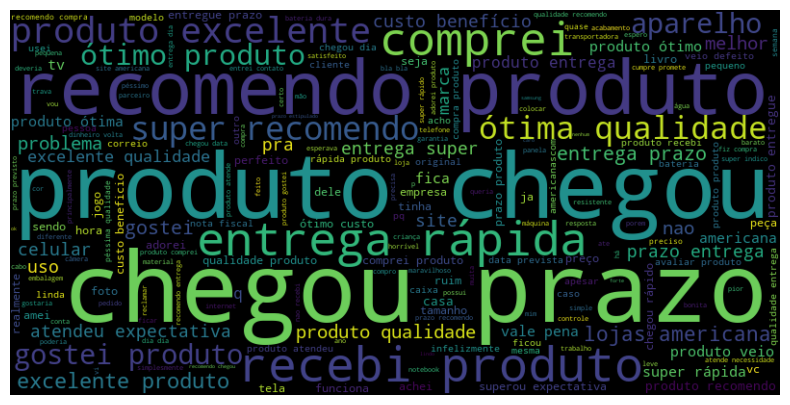

In [80]:
# Plota o WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

##### wordcloud sem aplicação de stopwords

In [85]:
# Combina todos os textos em uma única string
texto_completo_2 = ' '.join(b2w['review_text'])

In [87]:
# Cria um objeto WordCloud
wordcloud_2 = WordCloud(width=800, height=400, background_color='black').generate(texto_completo_2)

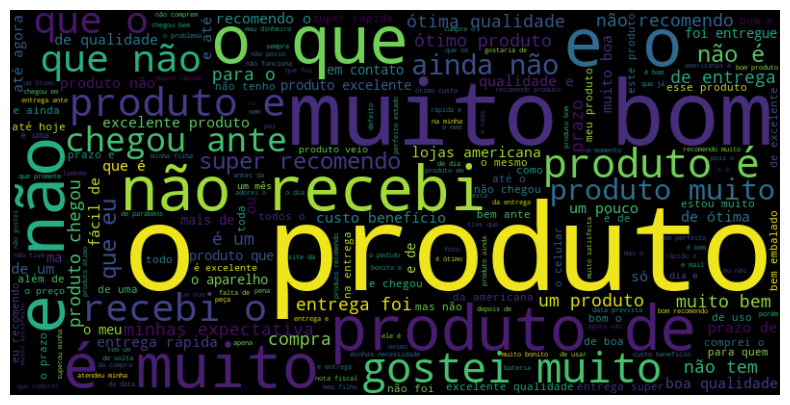

In [88]:
# Plota o WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_2, interpolation='bilinear')
plt.axis('off')
plt.show()